# Quickstart

This document tries to follow the [tskit quickstart](https://tskit.dev/tskit/docs/stable/quickstart.html).

A *tree sequence* represents the ancestral relationships between a set of DNA sequences. It provides an efficient way to store genetic variation data. For a more comprehensive description of *tree sequence* see [What is a tree sequence?](https://tskit.dev/tutorials/what_is.html)

Any *tree sequences* generated or not with [msprime](https://tskit.dev/msprime/docs/stable/intro.html) can be loaded and a summary table printed

In [1]:
import tskit
import string
import numpy as np

from tskitetude import get_project_dir

Collect the `` from GitHub:

```bash
wget https://github.com/tskit-dev/tskit/raw/main/docs/data/basic_tree_seq.trees -O data/basic_tree_seq.trees
```

In [2]:
# load a sample tree sequence
ts = tskit.load(get_project_dir() / "data/basic_tree_seq.trees")  # Or generate using e.g. msprime.sim_ancestry()
ts  # In a Jupyter notebook this displays a summary table. Otherwise use print(ts)

Get and print first tree in sequence:

Total branch length in first tree is 4496.0 generations
The first of 4 trees is plotted below


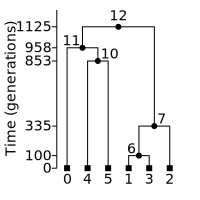

In [3]:
first_tree = ts.first()
print("Total branch length in first tree is", first_tree.total_branch_length, ts.time_units)
print("The first of", ts.num_trees, "trees is plotted below")
first_tree.draw_svg(y_axis=True)  # plot the tree: only useful for small trees

Printing trees with mutation sites:

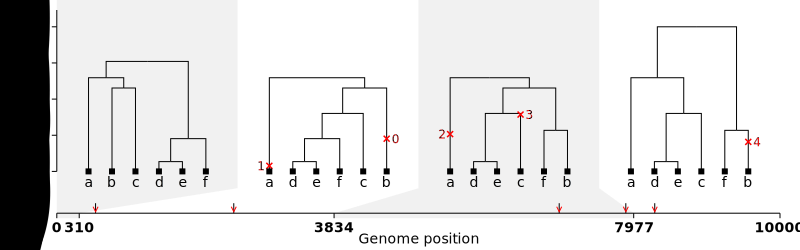

In [4]:
# Extra code to label and order the tips alphabetically rather than numerically
labels = {i: string.ascii_lowercase[i] for i in range(ts.num_nodes)}
genome_order = [n for n in ts.first().nodes(order="minlex_postorder") if ts.node(n).is_sample()]
labels.update({n: labels[i] for i, n in enumerate(genome_order)})
style1 = (
    ".node:not(.sample) > .sym, .node:not(.sample) > .lab {visibility: hidden;}"
    ".mut {font-size: 12px} .y-axis .tick .lab {font-size: 85%}")
sz = (800, 250)  # size of the plot, slightly larger than the default

# ticks = [0, 5000, 10000, 15000, 20000]
# get max generations time:
max_time = ts.node(ts.get_num_nodes() - 1).time
ticks = np.linspace(0, max_time, 5)
ts.draw_svg(
    size=sz, node_labels=labels, style=style1, y_label="Time ago",
    y_axis=True, y_ticks=ticks)

## Extract genetic data
A tree sequence provides an extremely compact way to store [genetic variation data](https://tskit.dev/tutorials/what_is.html#sec-what-is-dna-data). The trees allow this data to be decoded at each site:

In [5]:
for variant in ts.variants():
    print(
        "Variable site", variant.site.id,
        "at genome position", variant.site.position,
        ":", [variant.alleles[g] for g in variant.genotypes],
    )

Variable site 0 at genome position 536.0 : ['A', 'A', 'A', 'A', 'G', 'A']
Variable site 1 at genome position 2447.0 : ['C', 'G', 'G', 'G', 'G', 'G']
Variable site 2 at genome position 6947.0 : ['G', 'C', 'C', 'C', 'C', 'C']
Variable site 3 at genome position 7868.0 : ['C', 'C', 'C', 'C', 'C', 'T']
Variable site 4 at genome position 8268.0 : ['C', 'C', 'C', 'C', 'T', 'C']


Here is how I can display mutations in trees (adapted from [An efficient encoding of DNA data](https://tskit.dev/tutorials/what_is.html#sec-what-is-dna-data)):

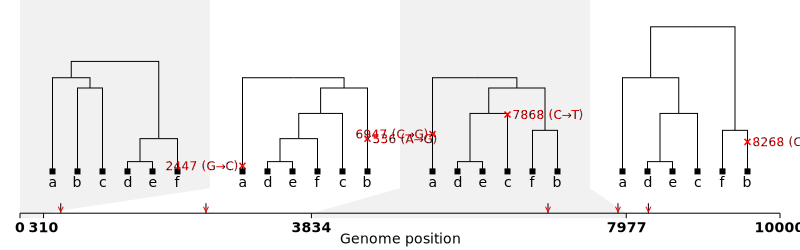

In [6]:
mut_labels = {}  # An array of labels for the mutations, listing position & allele change
l = "{:g} ({}→{})"
for mut in ts.mutations():  # This entire loop is just to make pretty labels
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = l.format(site.position, prev, mut.derived_state)

# Extra code to label and order the tips alphabetically rather than numerically
labels = {i: string.ascii_lowercase[i] for i in range(ts.num_nodes)}
genome_order = [n for n in ts.first().nodes(order="minlex_postorder") if ts.node(n).is_sample()]
labels.update({n: labels[i] for i, n in enumerate(genome_order)})
style1 = (
    ".node:not(.sample) > .sym, .node:not(.sample) > .lab {visibility: hidden;}"
    ".mut {font-size: 12px} .y-axis .tick .lab {font-size: 85%}")
sz = (800, 250)  # size of the plot, slightly larger than the default

ts.draw_svg(
    size=sz, style=style1, node_labels=labels, mutation_labels=mut_labels)

## Analysis

Tree sequences enable efficient [analysis](https://tskit.dev/tutorials/what_is.html#sec-what-is-analysis) 
of genetic variation using a comprehensive range of built-in [Statistics](https://tskit.dev/tskit/docs/stable/stats.html#sec-stats):

In [7]:
genetic_diversity = ts.diversity()
print("Av. genetic diversity across the genome is", genetic_diversity)

branch_diversity = ts.diversity(mode="branch")
print("Av. genealogical dist. between pairs of tips is", branch_diversity,  ts.time_units)

Av. genetic diversity across the genome is 0.00016666666666666666
Av. genealogical dist. between pairs of tips is 1645.8752266666668 generations


## Plotting the whole tree sequence
This can give you a visual feel for small genealogies:

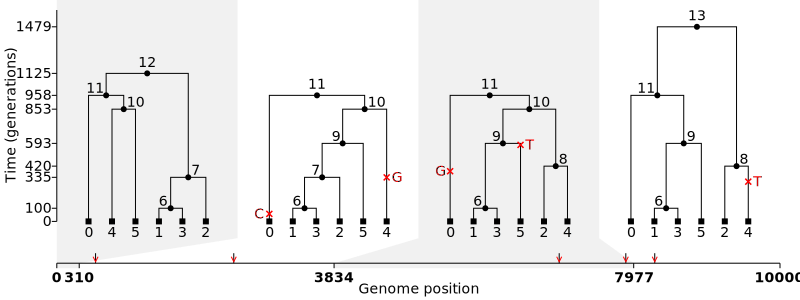

In [8]:
ts.draw_svg(
    size=(800, 300),
    y_axis=True,
    mutation_labels={m.id: m.derived_state for m in ts.mutations()},
)

## Underlying data structures
The data that defines a tree sequence is stored in a set of tables. These tables
can be viewed, and copies of the tables can be edited to create a new tree sequence.

In [9]:
# The sites table is one of several tables that underlie a tree sequence
ts.tables.sites

id,position,ancestral_state,metadata
0,536,A,
1,2447,G,
2,6947,C,
3,7868,C,
4,8268,C,
